# Аналитика в Яндекс.Афише

Необходимо провести анализ данных от Яндекс.Афиши (лог сервера с данными о посещениях сайта Яндекс.Афиши, выгрузка всех заказов за этот период, статистика рекламных расходов) с июня 2017 по конец мая 2018 года с целью оптимизации маркетинговых затрат.


Необходимо изучить:
- как люди пользуются продуктом
- когда они начинают покупать
- сколько денег приносит каждый клиент
- когда клиент окупается

### План

1. Загрузка и подготовка данных


2. Построение отчёта и подсчет метрик


 - _Продукт:_

   - Сколько людей пользуются в день, неделю, месяц? 
   - Сколько сессий в день?
   - Сколько длится одна сессия?
   - Как часто люди возвращаются?
  
  
 - _Продажи:_

   - Когда люди начинают покупать? 
   - Сколько раз покупают за период? 
   - Какой средний чек?
   - Сколько денег приносят? (LTV)


 - _Маркетинг:_
   - Сколько денег потратили? Всего / на каждый источник / по времени 
   - Сколько стоило привлечение одного покупателя из каждого источника? 
   - На сколько окупились расходы? (ROI)
   
   
 - Построение графиков отличия метрик по устройствам и рекламным источникам. Исследование их изменений во времени


3. Выводы. 
    - Куда и сколько стоит вкладывать денег?
    - Какие источники/платформы рекомендованны? (Пояснение на какие метрики ориентировались? Почему? Какие выводы сделаны?)

### Описание данных

Таблица ___visits___ (лог сервера с информацией о посещениях сайта):
- __Uid__ — уникальный идентификатор пользователя 
- __Device__ — категория устройства пользователя 
- __Start Ts__ — дата и время начала сессии
- __End Ts__ — дата и время окончания сессии
- __Source Id__ — идентификатор рекламного источника, из которого пришел пользователь

Путь: _/datasets/visits_log.csv_

Таблица ___orders___ (информация о заказах):
- __Uid__ — уникальный id пользователя, который сделал заказ 
- __Buy Ts__ — дата и время заказа
- __Revenue__ — выручка Яндекс.Афиши с этого заказа

Путь: _/datasets/orders_log.csv_

Таблица ___costs___ (информация о затратах на маркетинг):
- __source_id__ — идентификатор рекламного источника
- __dt__ — дата
- __costs__ — затраты на этот рекламный источник в этот день

Путь: _/datasets/costs.csv_

## 1. Загрузка и подготовка данных

In [1]:
# импорт необходимых библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

import seaborn as sns
sns.set()
sns.set_style("darkgrid", {"axes.facecolor": ".9"}) # стиль графиков в отчете

In [2]:
# загружаем датасеты

# лог сервера с информацией о посещениях сайта
visits = pd.read_csv('/datasets/visits_log.csv')

# информация о заказах
orders = pd.read_csv('/datasets/orders_log.csv')

# информация о затратах на маркетинг
costs = pd.read_csv('/datasets/costs.csv')

### _visits_

In [3]:
# первые 5 строк датасета
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Данные без пропусков, названия столбцов имеют пробелы, а также заглавные буквы. Типы данных в столбцах ___'Start Ts'___, ___'End Ts'___ не соответствуют данным, записанным в данные столбцы (необходимо изменить тип данных на формат даты). 

In [5]:
# функция замены пробелов на "_" и приведение к нижнему регистру
    # data - датафрейм
def space_del_str_lower(data):
    data.columns = data.columns.str.replace(' ', '_').str.lower()

In [6]:
# приводим к нижнему регистру, убираем пробелы
space_del_str_lower(visits)

In [7]:
# пересортировываем столбцы для удобства
visits = visits[['uid', 'source_id', 'device', 'start_ts', 'end_ts']]

In [8]:
# приводим типы данных в соответствие с записанными данными
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])

In [9]:
print('Количество строк, где время начала сессии позже времени окончания, а также время сессии нулевое:', end=' ')
print(visits[visits['start_ts'] >= visits['end_ts']].shape[0])

Количество строк, где время начала сессии позже времени окончания, а также время сессии нулевое: 35796


In [10]:
# исключаем строки, где время начала позже времени конца сессии, а также продолжительность сессии 0 секунд
visits = visits.query('end_ts > start_ts')

Данные в датасете подготовлены, тип данных, не соответствующий хранящейся информации изменен методом ___pd.to_datetime___.

### _orders_

In [11]:
# первые 5 строк датасета
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Данные без пропусков, названия столбцов имеют пробелы, а также заглавные буквы. Тип данных в столбце ___'Buy Ts'___ не соответствуют данным, записанным в данный столбец (необходимо изменить тип данных на формат даты).

In [13]:
# приводим к нижнему регистру, убираем пробелы
space_del_str_lower(orders)

In [14]:
# пересортировываем столбцы для удобства
orders = orders[['uid', 'buy_ts', 'revenue']]

In [15]:
# приводим тип данных в соответствие с записанными данными
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

Данные в датасете подготовлены, тип данных, не соответствующий хранящейся информации изменен методом pd.to_datetime.

### _costs_

In [16]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [17]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Данные без пропусков, названия столбцов имеют пробелы, а также заглавные буквы. Тип данных в столбце 'Buy Ts' не соответствуют данным, записанным в данный столбец (необходимо изменить тип данных на формат даты).

In [18]:
# приводим тип данных в соответствие с записанными данными
costs['dt'] = pd.to_datetime(costs['dt'])

#### Выводы

Были загружены 3 датасета ___visits___ (лог сервера с информацией о посещениях сайта), ___orders___ (информация о заказах), ___costs___ (информация о затратах на маркетинг). Данные без пропусков, в таблицах ___visits___ и ___orders___ названия столбцов были приведены к нижнему регистру функцией _.str.lower()_

## 2. Построение отчёта и подсчет метрик

### _Продукт_

Для подсчета метрик активности пользователей в день, неделю и месяц выделим из столбца, в котором хранится время начала сессии, полную дату, неделю, месяц, год. 

In [19]:
# выделяем из столбца начала сессии:

    # полную дату
visits['date'] = visits['start_ts'].dt.date

    # неделю
visits['week'] = visits['start_ts'].dt.week

    # месяц
visits['month'] = visits['start_ts'].dt.month

    # год
visits['year'] = visits['start_ts'].dt.year

- Найдем количество уникальных пользователей в день (__DAU__), неделю (__WAU__) и месяц (__MAU__). 

In [20]:
# функция нахождения DAU, WAU, MAU
    # xau - что ищем
        # 'dau', 'wau', 'mau'
    # by_what - по какому параметру искать
        # 'device' - по девайсу
        # 'source_id' - по рекламному источнику
        
def find_dau_wau_mau(xau, by_what):
    
    # группируем данные, находим число заходов
    if xau == 'dau':
        temp_df = (
            visits.groupby([by_what, 'date'])
            .agg({'uid': 'nunique'})
        )
        
    elif xau == 'wau':
        temp_df = (
            visits.groupby([by_what, 'year', 'week'])
            .agg({'uid': 'nunique'})
        )
        
    elif xau == 'mau':
        temp_df = (
            visits.groupby([by_what, 'year', 'month'])
            .agg({'uid': 'nunique'})
        )
    
    # формируем сводную таблицу с искомыми параметрами
    temp_pivot = (
        (
            temp_df.pivot_table(index=by_what,
                                values='uid',
                                aggfunc='mean')
            .round()
            .astype('int')
        ).rename(columns={'uid': xau})
    )

    return temp_pivot

   * _Уникальные пользователи в разбивке по устройствам_

In [21]:
# день
dau_per_device = find_dau_wau_mau('dau', 'device')

# неделя
wau_per_device = find_dau_wau_mau('wau', 'device')

# месяц
mau_per_device = find_dau_wau_mau('mau', 'device')

In [22]:
# функция отрисовки графика
    # by - условие для заголовка

def draw_dau_mau_wau(dau, wau, mau, by):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3,figsize=(15,6))
    fig.suptitle('Количество уникальных пользователей в разбивке ' + by, fontsize=15, style="italic")

    sns.barplot(data=dau,
                x=dau.index,
                y=dau.columns[0],
                ax=ax1)

    sns.barplot(data=wau,
                x=wau.index,
                y=wau.columns[0],
                ax=ax2)

    sns.barplot(data=mau,
                x=mau.index,
                y=mau.columns[0],
                ax=ax3)

    ax1.set_ylabel('Количество уникальных пользователей\n')
    ax1.set_xlabel('Уникальные пользователи за день \n(DAU)')

    ax2.set_xlabel('Уникальные пользователи за неделю \n(WAU)')
    ax2.set_ylabel('')

    ax3.set_xlabel('Уникальные пользователи за месяц \n(MAU)')
    ax3.set_ylabel('');

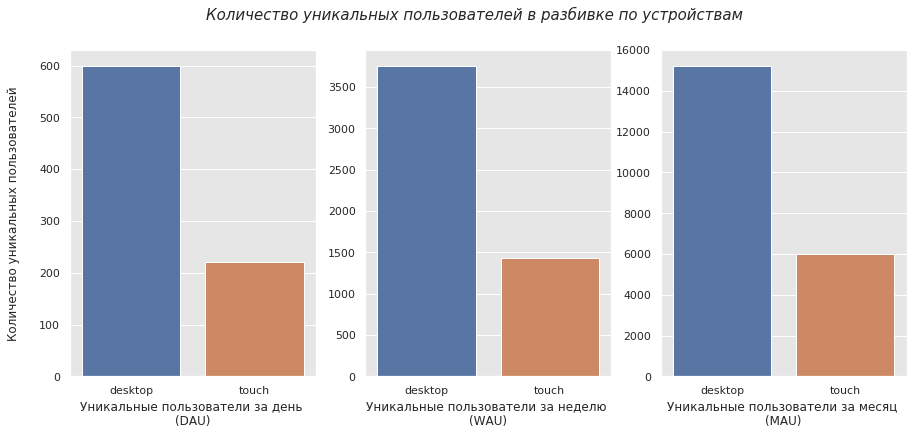

In [23]:
# рисуем график
draw_dau_mau_wau(dau_per_device, wau_per_device, mau_per_device, 'по устройствам')

   * _Уникальные пользователи в разбивке по рекламным источникам_

In [24]:
# день
dau_per_source = find_dau_wau_mau('dau', 'source_id')

# неделя
wau_per_source = find_dau_wau_mau('wau', 'source_id')

# месяц
mau_per_source = find_dau_wau_mau('mau', 'source_id')

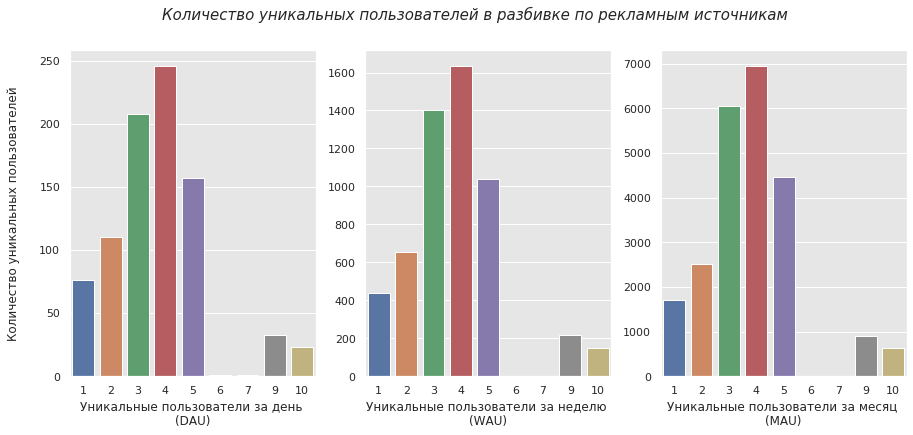

In [25]:
# рисуем график
draw_dau_mau_wau(dau_per_source, wau_per_source, mau_per_source, 'по рекламным источникам')

- Количество сессий в день. 

In [26]:
# поиск количества сессий и пользователей на каждый день
    # what - по какому параметру ищем
    
def find_sessions_per(what):
    
    # считаем количество сессий и пользователей на каждый день
    temp =  visits.groupby([what,'date']).agg({'uid':['count', 'nunique']})
    
    # для удобства переименовываем столбцы
    temp.columns = ['number_of_sessions', 'number_of_users']
    
    # находим среднее количество сессий в день
    temp['number_sess'] = temp['number_of_sessions'] / temp['number_of_users']
    
    
    temp_group = temp.groupby(what).agg({'number_sess': 'mean'})
    return temp_group

In [27]:
sessions_per_day_by_device = find_sessions_per('device')
sessions_per_day_by_source = find_sessions_per('source_id')

Построим график, отображающий среднее количество сессий за день по устройствам и рекламным источникам. Для большей детализации используем минимальное значение количества дней - 0.95.

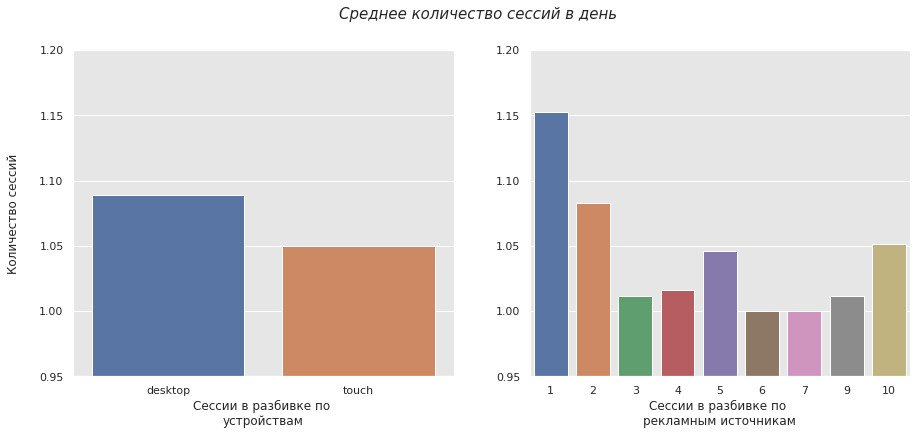

In [28]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(15,6))
fig.suptitle('Среднее количество сессий в день', fontsize=15, style="italic")

sns.barplot(data=sessions_per_day_by_device,
                x=sessions_per_day_by_device.index,
                y=sessions_per_day_by_device['number_sess'],
                ax=ax1)

sns.barplot(data=sessions_per_day_by_source,
                x=sessions_per_day_by_source.index,
                y=sessions_per_day_by_source['number_sess'],
                ax=ax2)

ax1.set_ylabel('Количество сессий\n')
ax1.set_xlabel('Сессии в разбивке по \nустройствам')
ax1.set_ylim(0.95, 1.2)

ax2.set_xlabel('Сессии в разбивке по \nрекламным источникам')
ax2.set_ylabel('')
ax2.set_ylim(0.95, 1.2);

- Длительность одной сессии. 

In [29]:
# считаем длительность одной взятой сессии в секундах
visits['session_duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

In [30]:
# находим среднюю длительность сессии
    # по устройствам
asl_by_device = visits.pivot_table(index='device',
                                   values='session_duration',
                                   aggfunc=pd.Series.mode)

    # по рекламным источникам
asl_by_source = visits.pivot_table(index='source_id',
                                   values='session_duration',
                                   aggfunc=pd.Series.mode)
asl_by_source['session_duration'][6] = asl_by_source['session_duration'][6].mean()

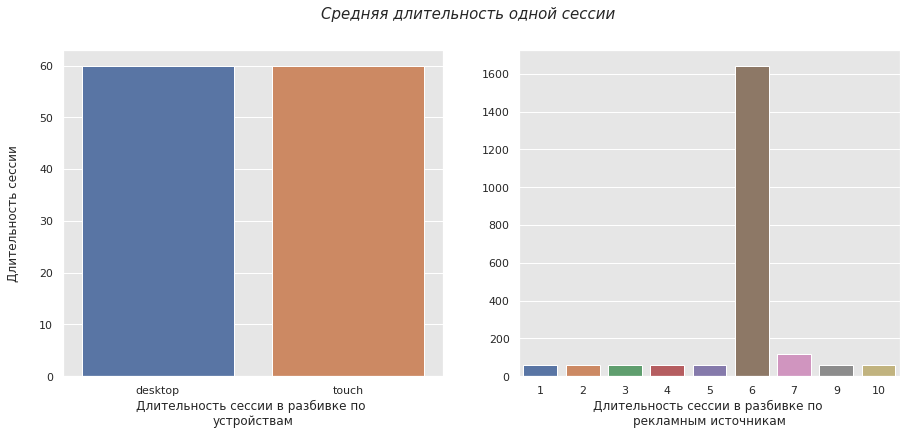

In [31]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(15,6))
fig.suptitle('Средняя длительность одной сессии', fontsize=15, style="italic")

sns.barplot(data=asl_by_device,
                x=asl_by_device.index,
                y=asl_by_device['session_duration'],
                ax=ax1)

sns.barplot(data=asl_by_source,
                x=asl_by_source.index,
                y=asl_by_source['session_duration'],
                ax=ax2)

ax1.set_ylabel('Длительность сессии\n')
ax1.set_xlabel('Длительность сессии в разбивке по \nустройствам')

ax2.set_xlabel('Длительность сессии в разбивке по \nрекламным источникам')
ax2.set_ylabel('');

- Подсчитаем частоту возвращений пользователей - __Retention Rate__

In [32]:
# находим время первого захода для кажного пользователя
first_activity_datetime = (
    visits.groupby('uid').agg({'start_ts': 'min'})
    .rename(columns={'start_ts': 'first_activity_datetime'})
)

In [33]:
# соотносим время первого захода с пользователями
visits = visits.merge(first_activity_datetime, on='uid')

In [34]:
# находим первый источник пользователя
find_first_source = (
    visits.query('start_ts == first_activity_datetime')[['uid', 'source_id']]
    .rename(columns={'source_id': 'first_source'})
)

In [35]:
# соотносим первый источник с пользователями
visits = visits.merge(find_first_source, on='uid')

In [36]:
# находим месяц первой активности
visits['first_activity_month'] = visits['first_activity_datetime'].astype('datetime64[M]')

In [37]:
# ищем время жизни когорты
visits['cohort_lifetime'] = (
    (
        (visits['date'].astype('datetime64[M]') - visits['first_activity_month']) / 
        np.timedelta64(1, 'M')
    ).round().astype('int')
)

In [38]:
# формируем когорты
cohorts = visits.groupby(['first_activity_month', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()

In [39]:
# находим исходное количество пользователей
initial_users = (
    cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month', 'uid']]
    .rename(columns={'uid': 'cohort_users'})
)

In [40]:
# объединяем
cohorts = cohorts.merge(initial_users, on='first_activity_month')

In [41]:
# считаем retention
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

In [42]:
# формируем сводную таблицу
retention_rate = cohorts.pivot_table(index='first_activity_month', 
                                     columns='cohort_lifetime', 
                                     values='retention',
                                     aggfunc='sum')

# сотавляем только год и месяц когорты
retention_rate.index = retention_rate.index.strftime('%Y-%m')

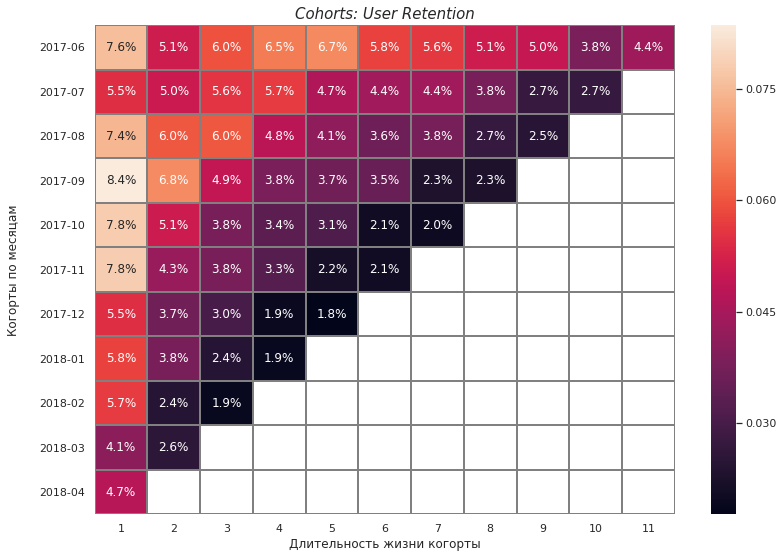

In [43]:
# строим тепловую карту
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention', fontsize=15, style="italic")
ax = sns.heatmap(retention_rate.loc[:'2018-04',1:], annot=True, fmt='.1%', linewidths=1, linecolor='gray')
ax.set_ylabel('Когорты по месяцам\n')
ax.set_xlabel('Длительность жизни когорты');

### _Продажи_

- Когда люди начинают покупать

In [44]:
# находим дату покупки
orders['buy_date'] = orders['buy_ts'].astype('datetime64[D]')

In [45]:
# находим дату первой покупки
first_buy_date = (
    orders.groupby('uid').agg({'buy_date': 'min'})
    .reset_index()
    .rename(columns={'buy_date': 'first_buy_date'})
)

In [46]:
# добавляем информацию о первом заказе
orders = orders.merge(first_buy_date, on='uid')

# информация о ресурсе
orders = orders.merge(find_first_source, on='uid')

In [47]:
# добавляем пользователям дату первого захода на сайт
time_to_buy = (
    orders.join(first_activity_datetime, on='uid')
    [['uid', 'first_buy_date', 'first_activity_datetime', 'first_source']]
)

In [48]:
# приводим к нужному типу данных
time_to_buy['first_activity_date'] = time_to_buy['first_activity_datetime'].astype('datetime64[D]')

# фильтруем пользователей, у которых первая покупка совершена раньше первого захода на сайт
time_to_buy = time_to_buy.query('first_buy_date >= first_activity_date')

In [49]:
# находим количество дней, прошедших с дня первого захода до первой покупки
time_to_buy['days_to_buy'] = (
    (
    (time_to_buy['first_buy_date'] - time_to_buy['first_activity_date']) / np.timedelta64(1, 'D'))
    .round()
    .astype('int')
)

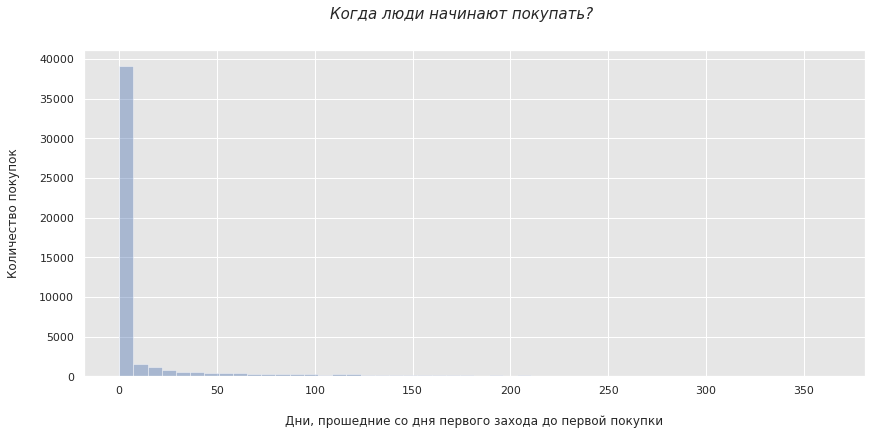

In [50]:
sns.set()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, ax= plt.subplots(figsize=(14,6))
fig.suptitle('Когда люди начинают покупать?', fontsize=15, style="italic")

sns.distplot(time_to_buy['days_to_buy'],kde=False, rug=False, ax=ax)

ax.set_ylabel('Количество покупок\n')
ax.set_xlabel('\nДни, прошедние со дня первого захода до первой покупки');

Чаще всего покупают в первые несколько дней. Распределение не нормальное, поэтому для нахождения среднего количества дней со дня первого захода до первой покупки используем моду.

In [51]:
print('Среднее количество дней, прошедших с дня первого захода до первой покупки:', end=' ')
print('{} дней'.format(time_to_buy['days_to_buy'].mode()[0]))

Среднее количество дней, прошедших с дня первого захода до первой покупки: 0 дней


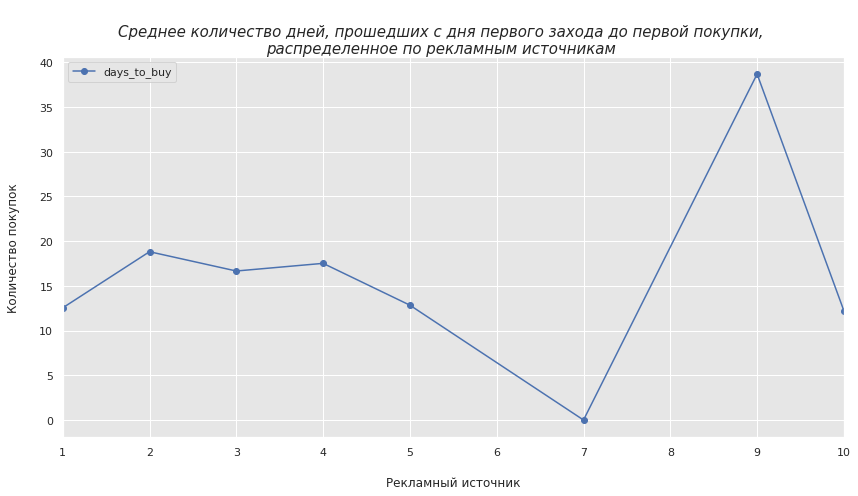

In [52]:
fig, ax = plt.subplots(figsize=(14,7))
fig.suptitle('\nСреднее количество дней, прошедших с дня первого захода до первой покупки,\n'
    +'распределенное по рекламным источникам', fontsize=15, style="italic")


time_to_buy.pivot_table(index='first_source', values='days_to_buy',aggfunc='mean').plot(style='o-', ax=ax)

ax.set_ylabel('Количество покупок\n')
ax.set_xlabel('\nРекламный источник');

- Сколько раз покупают за период?

In [53]:
# выделяем месяц покупки
orders['buy_month'] = orders['buy_date'].astype('datetime64[M]')

In [54]:
# находим общее количество покупок по месяцам
orders_by_month = (
    orders.pivot_table(index='buy_month', values='uid', aggfunc='count')
    .rename(columns={'uid': 'orders'})
)

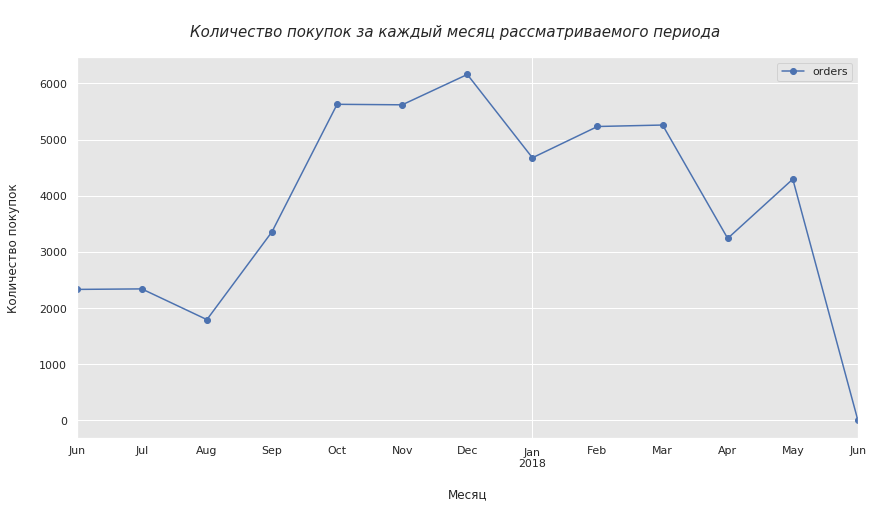

In [55]:
fig, ax = plt.subplots(figsize=(14,7))
fig.suptitle('\nКоличество покупок за каждый месяц рассматриваемого периода', fontsize=15, style="italic")

orders_by_month.plot(style='o-', ax=ax)

ax.set_ylabel('Количество покупок\n')
ax.set_xlabel('\nМесяц');

In [56]:
# находим общее количество покупок по рекламным источникам
orders_by_source = (
    orders.pivot_table(index='buy_month',columns='first_source', values='uid', aggfunc='count')
    .rename(columns={'uid': 'orders'})
)

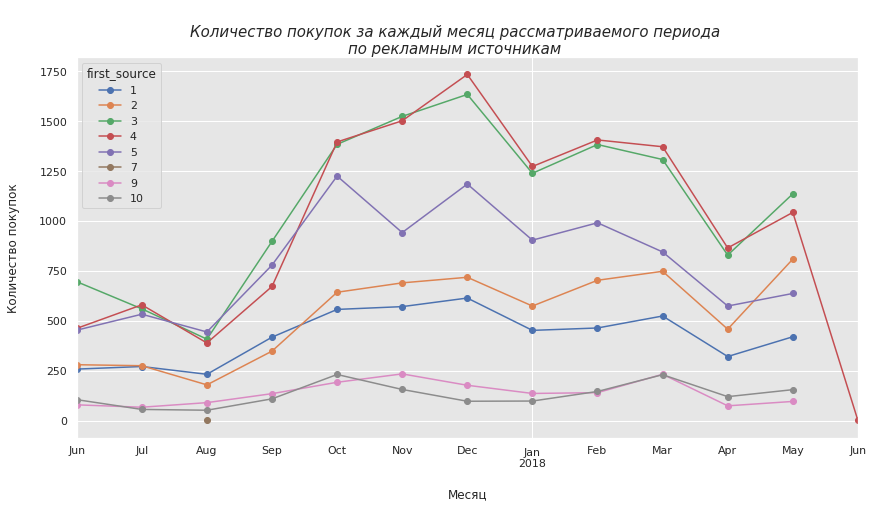

In [57]:
fig, ax = plt.subplots(figsize=(14,7))
fig.suptitle('\nКоличество покупок за каждый месяц рассматриваемого периода\n'
             +'по рекламным источникам', fontsize=15, style="italic")

orders_by_source.plot(style='o-', ax=ax)

ax.set_ylabel('Количество покупок\n')
ax.set_xlabel('\nМесяц');

- Какой средний чек?

In [58]:
# находим средний чек за месяц
revenue_per_month = orders.pivot_table(index='buy_month', values='revenue',
                                              aggfunc='mean')

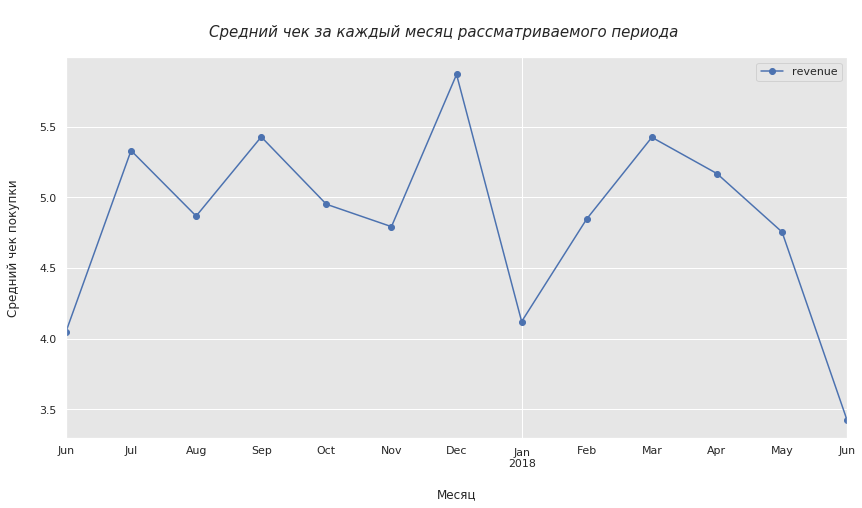

In [59]:
fig, ax = plt.subplots(figsize=(14,7))
fig.suptitle('\nСредний чек за каждый месяц рассматриваемого периода', fontsize=15, style="italic")

revenue_per_month.plot(style='o-', ax=ax)

ax.set_ylabel('Средний чек покупки\n')
ax.set_xlabel('\nМесяц');

In [60]:
#  находим средний чек по рекламным источникам
revenue_per_source = orders.pivot_table(index='first_source', values='revenue',
                                              aggfunc='mean')

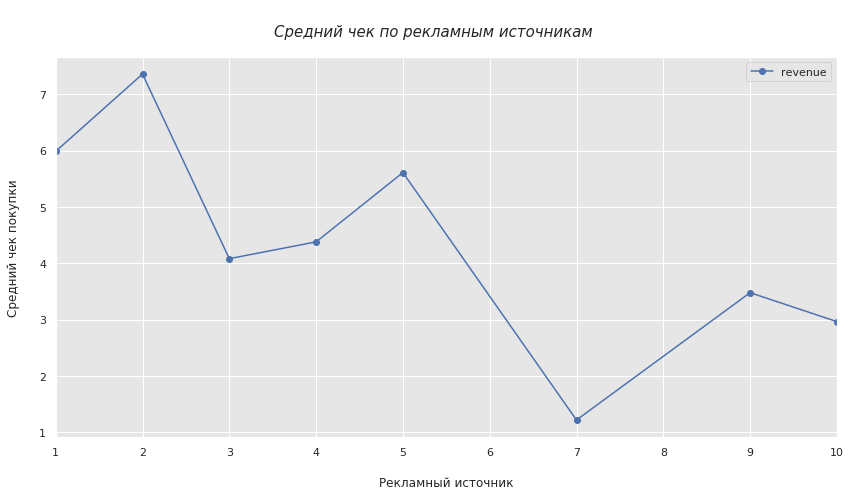

In [61]:
fig, ax = plt.subplots(figsize=(14,7))
fig.suptitle('\nСредний чек по рекламным источникам', fontsize=15, style="italic")

revenue_per_source.plot(style='o-', ax=ax)

ax.set_ylabel('Средний чек покупки\n')
ax.set_xlabel('\nРекламный источник');

- Сколько денег приносят? (LTV)

In [62]:
orders['first_buy_month'] = orders['first_buy_date'].astype('datetime64[M]')

In [63]:
# считаем количество уникальных покупателей по источнику и месяцу покупки.
orders_group = (
    orders.groupby(['first_buy_month','first_source'])
    .agg({'revenue': 'sum', 'uid': 'nunique'})
    .reset_index()
)
orders_group.columns = ['first_buy_month', 'first_source', 'revenue', 'n_buyers']
 
# принимаем маржинальность равной 100%
margin_rate = 1    
    
# считаем LTV
orders_group['ltv'] = (
    (orders_group['revenue'] * margin_rate) 
    / orders_group['n_buyers']
)

output_ltv = orders_group.pivot_table(
        index='first_source', 
        columns='first_buy_month', 
        values='ltv', 
        aggfunc='mean').round(2)

# сотавляем только год и месяц
output_ltv.columns = output_ltv.columns.strftime('%Y-%m')
    
output_ltv.fillna('')

,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06
first_source,,,,,,,,,,,,,
1,27.79,20.39,19.04,11.15,8.27,10.1,5.45,7.03,5.74,12.03,4.94,5.54,
2,16.7,11.67,8.38,26.37,12.63,9.65,36.42,7.79,6.6,7.29,6.21,7.54,
3,5.7,7.4,6.36,6.66,5.69,5,4.76,4.53,4.24,4.7,5.88,3.77,
4,12.14,6.29,6.41,7.79,5.24,6.74,4.53,4.1,4.26,4.77,5.34,4.28,3.42
5,14.42,6.15,10.05,26.5,6.17,5.28,5.4,5.36,4.5,4.96,4.33,4.21,
7,,,1.22,,,,,,,,,,
9,6.94,7.38,5.93,9.53,6.99,4.49,4.75,3.24,5.13,2.81,5.45,3.62,
10,2.47,8.33,5.65,2.61,2.82,5.03,4.09,3.16,2.57,3.6,2.49,3.62,


Средний LTV по источникам:

In [64]:
output_ltv.mean(axis=1).round(2)

first_source
1     11.46
2     13.10
3      5.39
4      5.79
5      8.11
7      1.22
9      5.52
10     3.87
dtype: float64

### _Маркетинг_

- Сколько денег потратили? Всего / на каждый источник / по времени

In [65]:
print('Всего на маркетинг потратили:', costs['costs'].sum())

Всего на маркетинг потратили: 329131.62


In [66]:
# разбивка затрат по источникам
costs_by_source = costs.pivot_table(index='source_id', values='costs', aggfunc='sum')

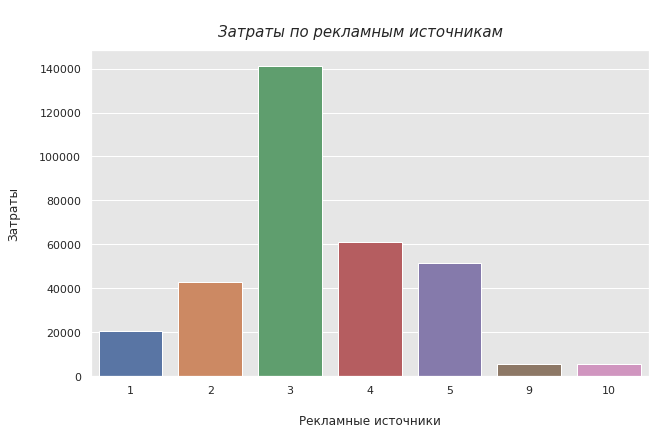

In [67]:
sns.set()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(ncols=1, figsize=(10,6))
fig.suptitle('\nЗатраты по рекламным источникам', fontsize=15, style="italic")

sns.barplot(data=costs_by_source,
                x=costs_by_source.index,
                y=costs_by_source['costs'],
                ax=ax)

ax.set_ylabel('Затраты\n')
ax.set_xlabel('\nРекламные источники');

In [68]:
costs['month'] = costs['dt'].astype('datetime64[M]')

In [69]:
# разбивка затрат по месяцам
costs_by_month = costs.pivot_table(index='month', values='costs', aggfunc='sum')

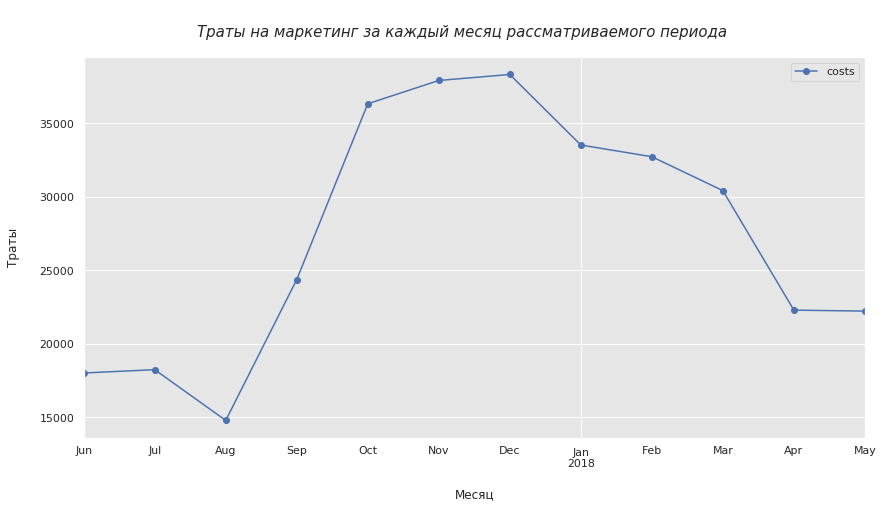

In [70]:
fig, ax = plt.subplots(figsize=(14,7))
fig.suptitle('\nТраты на маркетинг за каждый месяц рассматриваемого периода', fontsize=15, style="italic")

costs_by_month.plot(style='o-', ax=ax)

ax.set_ylabel('Траты\n')
ax.set_xlabel('\nМесяц');

- Сколько стоило привлечение одного покупателя из каждого источника? (CAC)

In [71]:
#сгруппируем расходы по месяцу и источнику
costs_group = costs.groupby(['source_id','month'])['costs'].sum().reset_index()
 
#обьеденим таблицы расходов и покупок.
result = orders_group.merge(costs_group, how = 'left', 
                            left_on =('first_buy_month', 'first_source'), 
                            right_on=('month', 'source_id'))
 
#Посчитаем расходы на одного покупателя (САС)
result['cac'] = result['costs'] / result['n_buyers']
 
output_cac = result.pivot_table(
        index='first_source',
        columns='first_buy_month',
        values='cac',
        aggfunc='mean').round(2)
# оставляем только год и месяц
output_cac.columns = output_cac.columns.strftime('%Y-%m')

In [72]:
output_cac

,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
first_source,,,,,,,,,,,,
1,5.92,6.46,8.42,6.39,6.73,7.32,6.91,9.00,7.76,6.69,7.29,5.85
2,10.46,11.33,14.72,13.27,12.58,13.02,12.62,14.24,15.01,11.74,14.05,6.50
3,12.27,15.38,18.12,13.09,13.95,14.27,12.58,15.02,13.36,13.96,15.29,11.58
4,8.57,6.91,9.66,9.00,5.53,4.63,5.71,5.80,5.26,5.63,6.51,5.35
5,6.87,7.19,6.21,6.64,6.15,9.19,7.70,8.47,7.59,8.80,8.34,7.47
9,4.19,5.71,4.08,4.72,4.80,4.91,5.31,6.59,6.49,3.00,9.58,6.04
10,3.42,6.47,6.29,5.30,3.04,6.29,7.78,6.98,3.97,2.86,3.70,3.25


- На сколько окупились расходы? (ROI)

In [73]:
# считаем ROMI на одного покупателя
result['romi'] = result['ltv'] / result['cac']
 
# выводим ROMI по месяцам с учетом рекламного источника
output_romi = result.pivot_table(
        index='first_source',
        columns='first_buy_month',
        values='romi',
        aggfunc='mean').round(4)
# оставляем только год и месяц
output_romi.columns = output_romi.columns.strftime('%Y-%m')
output_romi = output_romi.round(2)

In [74]:
output_romi

,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
first_source,,,,,,,,,,,,
1,4.69,3.15,2.26,1.74,1.23,1.38,0.79,0.78,0.74,1.80,0.68,0.95
2,1.60,1.03,0.57,1.99,1.00,0.74,2.89,0.55,0.44,0.62,0.44,1.16
3,0.46,0.48,0.35,0.51,0.41,0.35,0.38,0.30,0.32,0.34,0.38,0.33
4,1.42,0.91,0.66,0.87,0.95,1.45,0.79,0.71,0.81,0.85,0.82,0.80
5,2.10,0.86,1.62,3.99,1.00,0.57,0.70,0.63,0.59,0.56,0.52,0.56
9,1.66,1.29,1.45,2.02,1.46,0.91,0.89,0.49,0.79,0.94,0.57,0.60
10,0.72,1.29,0.90,0.49,0.93,0.80,0.53,0.45,0.65,1.26,0.67,1.11


Средние значения окупаемости маркетинговых затрат по устройствам:

In [75]:
output_romi.mean(axis=1).round(2)

first_source
1     1.68
2     1.09
3     0.38
4     0.92
5     1.14
9     1.09
10    0.82
dtype: float64

## 3. Выводы

Анализ количества посетителей в день, неделю и месяц по устройствам показал преобладание пользователей настольных устройств (ПК, лэптоп и т.д.). Ниже на графике отображено распределение:

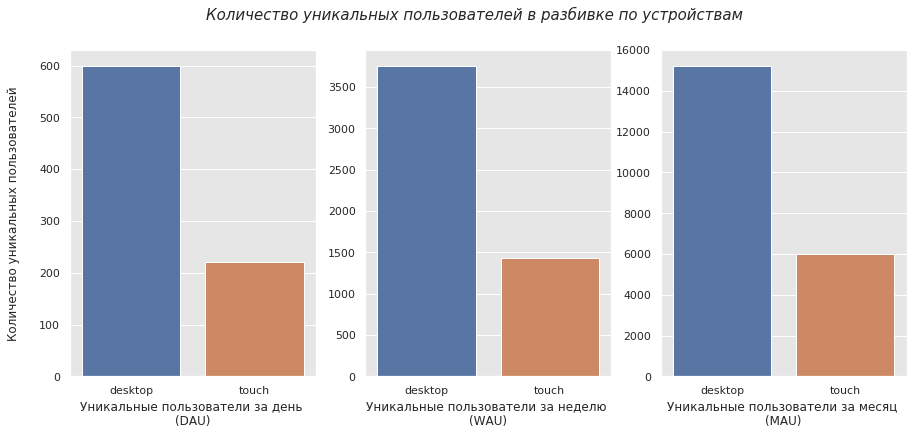

In [76]:
draw_dau_mau_wau(dau_per_device, wau_per_device, mau_per_device, 'по устройствам')

Исходя из того, что в текущее время пользователи больше потребляют информацию с карманных устройств (экранов телефонов, планшетов), стоит обратит внимание на повышение показателей посещаемости с таких устройств. Стоит проверить возможность удобного использования сайта с мобильного устройства и выяснить причину низких показателей посещаемости с данной платформы

По числу привлеченных уникальных пользователей лидирует 4 рекламный источник. Распределение ниже на графике. 

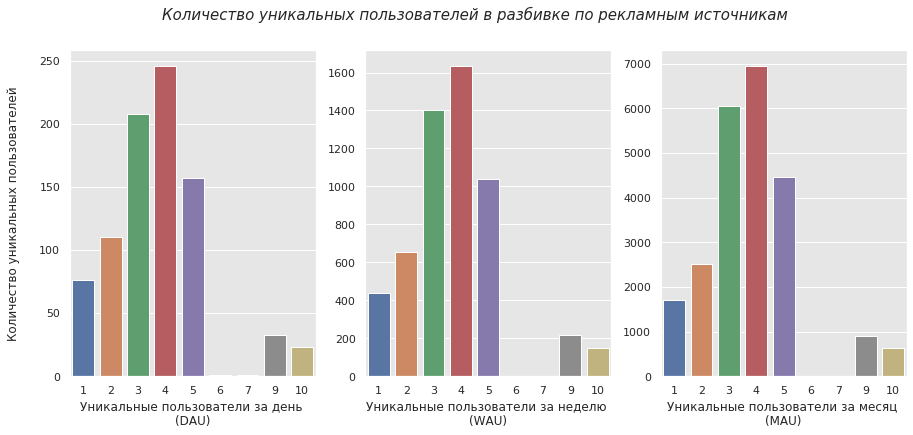

In [77]:
draw_dau_mau_wau(dau_per_source, wau_per_source, mau_per_source, 'по рекламным источникам')

Стоит и дальше продолжать финансировать 4 источник, увеличив его финансирование, чтобы привлечь еще больше пользователей, так как пока в среднем он убыточен, но имеет неплохой потенциал (см. таблицу 1 (ROMI) ниже). Стоит рассмотреть вариант снижения финансирования рекламного источника 3 - затраты на него более, чем в 2 раза превышают затраты на 4 источник, при значительной убыточности данного источника (см. График 1). При этом количество покупок в месяц меньше количества покупок, совершенных людьми, привлеченными из 4 источника. 

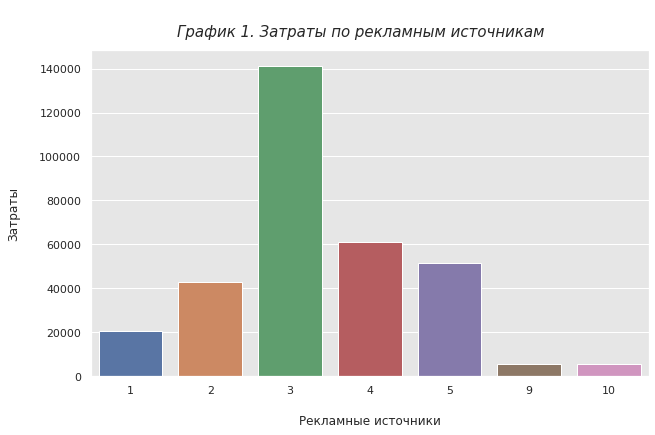

In [78]:
sns.set()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(ncols=1, figsize=(10,6))
fig.suptitle('\nГрафик 1. Затраты по рекламным источникам', fontsize=15, style="italic")

sns.barplot(data=costs_by_source,
                x=costs_by_source.index,
                y=costs_by_source['costs'],
                ax=ax)

ax.set_ylabel('Затраты\n')
ax.set_xlabel('\nРекламные источники');

Финансирование, освобожденное от 3 источника стоит перенаправить на источник 5 - кривая заказов по месяцам повторяет кривую источника 3 (значения заказов при этом меньше на 500), при меньшем финансировании (см. График 2). Если увеличить затраты на источник 5 - возможно ожидать увеличения количества заказов при снижении затрат на маркетинг. Ко всему прочему, 5 источник уже в среднем окупается. 

Также перспективным предлагаю считать источники 1 и 2 - их средние LTV являются самыми высокими среди всех рекламных источников, при этом затраты на маркетинг в среднем окупаются. 

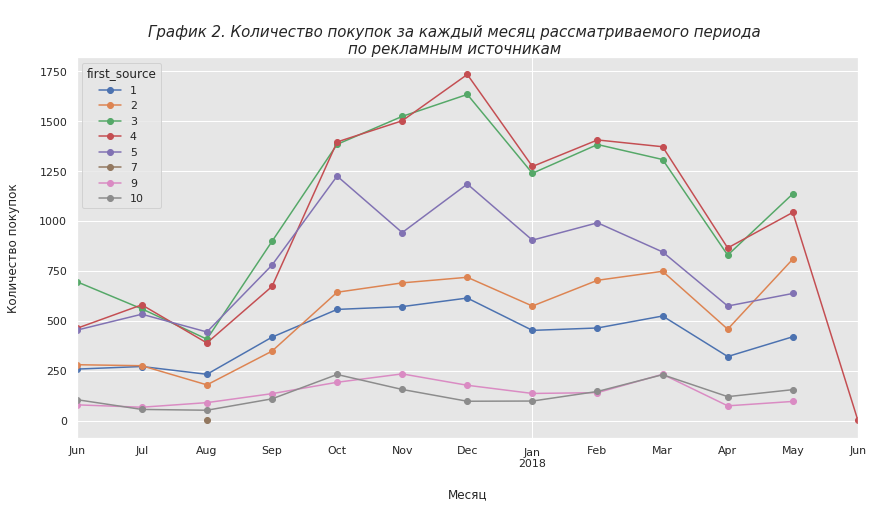

In [79]:
fig, ax = plt.subplots(figsize=(14,7))
fig.suptitle('\nГрафик 2. Количество покупок за каждый месяц рассматриваемого периода\n'
             +'по рекламным источникам', fontsize=15, style="italic")

orders_by_source.plot(style='o-', ax=ax)

ax.set_ylabel('Количество покупок\n')
ax.set_xlabel('\nМесяц');

In [80]:
output_romi.style.set_caption('Таблица 1. Возврат маркетинговых инвестиций (ROMI)')

,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
first_source,,,,,,,,,,,,
1,4.69,3.15,2.26,1.74,1.23,1.38,0.79,0.78,0.74,1.8,0.68,0.95
2,1.6,1.03,0.57,1.99,1,0.74,2.89,0.55,0.44,0.62,0.44,1.16
3,0.46,0.48,0.35,0.51,0.41,0.35,0.38,0.3,0.32,0.34,0.38,0.33
4,1.42,0.91,0.66,0.87,0.95,1.45,0.79,0.71,0.81,0.85,0.82,0.8
5,2.1,0.86,1.62,3.99,1,0.57,0.7,0.63,0.59,0.56,0.52,0.56
9,1.66,1.29,1.45,2.02,1.46,0.91,0.89,0.49,0.79,0.94,0.57,0.6
10,0.72,1.29,0.9,0.49,0.93,0.8,0.53,0.45,0.65,1.26,0.67,1.11


Средняя окупаемость маркетинговых затрат по рекламным источникам. 

In [81]:
output_romi.mean(axis=1).round(2)

first_source
1     1.68
2     1.09
3     0.38
4     0.92
5     1.14
9     1.09
10    0.82
dtype: float64